In [2]:
import re
import string
import json
import os
import glob
import shutil
from pprint import pprint
from functools import partial
from operator import itemgetter, attrgetter
from os.path import normpath
from typing import Callable

import joblib
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

import dask
import dask.dataframe as dd

# Set Seaborn theme and default palette
sns.set_theme(font_scale=1.25, style="darkgrid")
sns.set_palette("deep", desat=0.85, color_codes=True)

# Turn on inline plotting
%matplotlib inline

# Load Black auto-formatter
%load_ext nb_black

# Enable automatic reloading
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
# Import my modules
from tools import cleaning, plotting, language as lang, outliers, utils

# Set my default MPL settings
plt.rcParams.update(plotting.MPL_DEFAULTS)

dask.config.set(scheduler="processes")

<IPython.core.display.Javascript object>

# Initial Pruning

In [3]:
cols = ["description", "main_cat", "asin"]
df = dd.read_parquet("data/amazon", engine="pyarrow", columns=cols)
df = df.dropna(subset=["description", "main_cat"])
df

,description,main_cat,asin
npartitions=151,,,
,object,object,object
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


<IPython.core.display.Javascript object>

In [4]:
df.head()

,description,main_cat,asin
0,[(=^ ^=) 1.It is made of high quality material...,Movies & TV,6305121869
1,"[<b><br>Hi friend, welcome to our store. Befor...","<img src=""https://images-na.ssl-images-amazon....",6318708057
2,[Gaok men's pants are all made from cotton mat...,"<img src=""https://images-na.ssl-images-amazon....",6342506256
3,[<b>pant size(Unit:inch)</b><br> W30(tag30) Wa...,"<img src=""https://images-na.ssl-images-amazon....",6342509379
4,[All of our sunglasses offer protection agains...,Sports & Outdoors,6342522081


<IPython.core.display.Javascript object>

In [5]:
df = df.compute()
df

,description,main_cat,asin
0,[(=^ ^=) 1.It is made of high quality material...,Movies & TV,6305121869
1,"[<b><br>Hi friend, welcome to our store. Befor...","<img src=""https://images-na.ssl-images-amazon....",6318708057
2,[Gaok men's pants are all made from cotton mat...,"<img src=""https://images-na.ssl-images-amazon....",6342506256
3,[<b>pant size(Unit:inch)</b><br> W30(tag30) Wa...,"<img src=""https://images-na.ssl-images-amazon....",6342509379
4,[All of our sunglasses offer protection agains...,Sports & Outdoors,6342522081
...,...,...,...
22121,"[, CND Craft Culture Collection: Patina Buckle...",Luxury Beauty,B01HIQIEYC
22122,[CND Shellac was designed to be used as a syst...,Luxury Beauty,B01HIQHQU0
22123,[CND Shellac was designed to be used as a syst...,Luxury Beauty,B01HIQEOLO
22124,[The I AM JUICY COUTURE girl is once again tak...,Luxury Beauty,B01HJ2UY0W


<IPython.core.display.Javascript object>

In [6]:
df["description"] = df.loc[:, "description"].str.join(" ")
df.head()

,description,main_cat,asin
0,(=^ ^=) 1.It is made of high quality materials...,Movies & TV,6305121869
1,"<b><br>Hi friend, welcome to our store. Before...","<img src=""https://images-na.ssl-images-amazon....",6318708057
2,Gaok men's pants are all made from cotton mate...,"<img src=""https://images-na.ssl-images-amazon....",6342506256
3,<b>pant size(Unit:inch)</b><br> W30(tag30) Wai...,"<img src=""https://images-na.ssl-images-amazon....",6342509379
4,All of our sunglasses offer protection against...,Sports & Outdoors,6342522081


<IPython.core.display.Javascript object>

In [7]:
df = df.drop_duplicates(subset=["asin"])
df = df.drop_duplicates(subset=["description"])
df.shape

(8244935, 3)

<IPython.core.display.Javascript object>

In [8]:
df = df.set_index("asin")
df.head()

,description,main_cat
asin,,
6305121869,(=^ ^=) 1.It is made of high quality materials...,Movies & TV
6318708057,"<b><br>Hi friend, welcome to our store. Before...","<img src=""https://images-na.ssl-images-amazon...."
6342506256,Gaok men's pants are all made from cotton mate...,"<img src=""https://images-na.ssl-images-amazon...."
6342509379,<b>pant size(Unit:inch)</b><br> W30(tag30) Wai...,"<img src=""https://images-na.ssl-images-amazon...."
6342522081,All of our sunglasses offer protection against...,Sports & Outdoors


<IPython.core.display.Javascript object>

# Prune Length Outliers

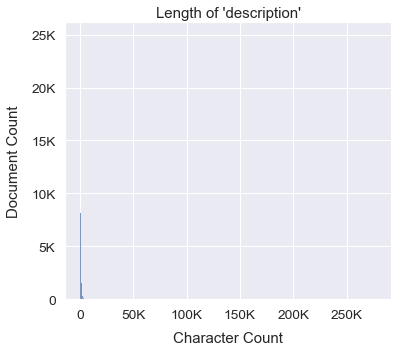

<IPython.core.display.Javascript object>

In [11]:
fig = lang.length_dist(df.sample(10 ** 6), subset="description")

In [12]:
lang.length_info(df.description)

        len_description
min                   0
median              387
max             278,061


<IPython.core.display.Javascript object>

In [13]:
df.loc[df.description.str.len().idxmax(), "description"]

'<div>Bryan Bunch has extensive experience as a writer and editor in the math and science fields. The editor of <i>The Family Encyclopedia of Diseases</i>, he is also the co-author, with Alexander Hellemans, of <i>The Timetables of Science</i> and the author of <i>Mathematical Fallacies and Paradoxes</i> and <i>Reality\'s Mirror: Exploring the Mathematics of Symmetry</i>, which was named one of the year\'s best science books by <i>Library Journal. </i> He lives in Pleasant Valley, New York.<br></div> <DIV>The Kingdom of Infinite Numbers<BR></div><DIV><DIV>Kingdom Number</div></div><DIV><DIV>Genus <i>Natural</i> (Counting Numbers)</div><DIV>In some societies, counting language has not evolved beyond 2 or 3 and a word that means "many" for higher numbers. From a linguistic point of view the counting numbers, at least those greater than 2 or 3, may be considered a human invention.</div><DIV>Yet there is something natural about the genus <i>Natural.</i> If the concept of matching, or one-t

<IPython.core.display.Javascript object>

The longest one isn't weird, it's just extremely long.

In [14]:
df.loc[df.description.str.len().idxmin(), "description"]

''

<IPython.core.display.Javascript object>

The shortest one is empty, which is obviously a problem.

In [22]:
df = lang.trim_length_outliers(df, subset="description", q_lower=0.5, q_upper=0.99)
df

        len_description
min                 387
median              790
max               4,231


             n_trimmed  pct_trimmed
description  4,203,654           51
main_cat             0            0
total_obs    4,203,654           51


,description,main_cat
asin,,
6305121869,(=^ ^=) 1.It is made of high quality materials...,Movies & TV
6318708057,"<b><br>Hi friend, welcome to our store. Before...","<img src=""https://images-na.ssl-images-amazon...."
6342506256,Gaok men's pants are all made from cotton mate...,"<img src=""https://images-na.ssl-images-amazon...."
6342509379,<b>pant size(Unit:inch)</b><br> W30(tag30) Wai...,"<img src=""https://images-na.ssl-images-amazon...."
6342522081,All of our sunglasses offer protection against...,Sports & Outdoors
...,...,...
B01HGSJPWM,"This luxurious hand and nail cream, enriched w...",Luxury Beauty
B01HGSJNEW,The unique infusion of exotic Tahitian Monoi O...,Luxury Beauty
B01HGSJPMW,This natural blend of highly concentrated plan...,Luxury Beauty


<IPython.core.display.Javascript object>

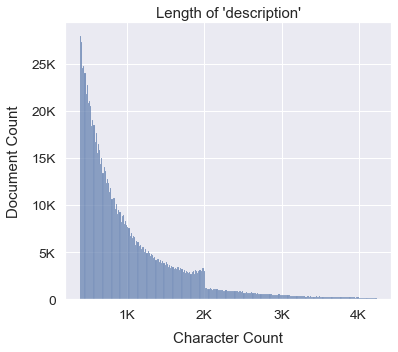

<IPython.core.display.Javascript object>

In [23]:
fig = lang.length_dist(df.sample(10 ** 6), subset="description")

# Clean 'main_cat'

In [24]:
is_html = df["main_cat"].str.match(r"^<\w+")
df.loc[is_html, "main_cat"] = (
    df.loc[is_html, "main_cat"].str.extract(r"alt=\"(.+)\"").squeeze()
)
df["main_cat"].unique()

array(['Movies & TV', 'AMAZON FASHION', 'Sports & Outdoors',
       'Toys & Games', 'Home Audio & Theater', 'Tools & Home Improvement',
       'Baby', 'Amazon Home', 'All Electronics', 'Health & Personal Care',
       'All Beauty', 'Office Products', 'Camera & Photo', 'Video Games',
       'Industrial & Scientific', 'Automotive', 'Computers',
       'Arts, Crafts & Sewing', 'Grocery', 'Musical Instruments',
       'Portable Audio & Accessories', 'Car Electronics', 'Digital Music',
       'Cell Phones & Accessories', 'Pet Supplies', 'Software',
       'Appliances', 'Books', 'Luxury Beauty', 'Amazon Devices',
       'Handmade', 'GPS & Navigation', 'Fine Art',
       'Health &amp; Personal Care', 'Arts, Crafts &amp; Sewing',
       'Toys &amp; Games', 'Industrial &amp; Scientific',
       'Tools &amp; Home Improvement', 'Sports &amp; Outdoors',
       'Camera &amp; Photo', 'Portable Audio &amp; Accessories',
       'Home Audio &amp; Theater', 'Cell Phones &amp; Accessories',
       'GPS &

<IPython.core.display.Javascript object>

In [25]:
df["main_cat"] = lang.decode_html_entities(df["main_cat"])
df["main_cat"] = df["main_cat"].str.lower()
df["main_cat"].unique()

array(['movies & tv', 'amazon fashion', 'sports & outdoors',
       'toys & games', 'home audio & theater', 'tools & home improvement',
       'baby', 'amazon home', 'all electronics', 'health & personal care',
       'all beauty', 'office products', 'camera & photo', 'video games',
       'industrial & scientific', 'automotive', 'computers',
       'arts, crafts & sewing', 'grocery', 'musical instruments',
       'portable audio & accessories', 'car electronics', 'digital music',
       'cell phones & accessories', 'pet supplies', 'software',
       'appliances', 'books', 'luxury beauty', 'amazon devices',
       'handmade', 'gps & navigation', 'fine art', 'apple products',
       'beats by dr. dre', 'collectibles & fine art',
       'sports collectibles', 'amazon launchpad', 'gift cards',
       'prime pantry', 'fire phone', 'amazon fire tv', 'buy a kindle',
       'magazine subscriptions', 'entertainment'], dtype=object)

<IPython.core.display.Javascript object>

In [26]:
df["main_cat"].value_counts()

books                           993233
amazon home                     495475
amazon fashion                  472189
sports & outdoors               251631
tools & home improvement        207008
toys & games                    204633
automotive                      199797
cell phones & accessories       148923
grocery                         146779
digital music                   117128
computers                       101978
movies & tv                     101547
office products                  72524
all electronics                  70566
pet supplies                     64613
industrial & scientific          61473
camera & photo                   60527
arts, crafts & sewing            58913
home audio & theater             45196
musical instruments              44611
video games                      27682
health & personal care           22372
baby                             12667
software                         12105
car electronics                  11261
all beauty               

<IPython.core.display.Javascript object>

In [27]:
df = utils.prune_categories(df, column="main_cat", cut=1e-5)
df["main_cat"].value_counts()

                          Dropped
amazon fire tv       2.474463e-07
amazon launchpad     1.237231e-06
apple products       1.237231e-06
beats by dr. dre     2.474463e-07
buy a kindle         2.474463e-07
entertainment        7.423389e-07
fire phone           7.423389e-07
sports collectibles  2.474463e-07


books                           993233
amazon home                     495475
amazon fashion                  472189
sports & outdoors               251631
tools & home improvement        207008
toys & games                    204633
automotive                      199797
cell phones & accessories       148923
grocery                         146779
digital music                   117128
computers                       101978
movies & tv                     101547
office products                  72524
all electronics                  70566
pet supplies                     64613
industrial & scientific          61473
camera & photo                   60527
arts, crafts & sewing            58913
home audio & theater             45196
musical instruments              44611
video games                      27682
health & personal care           22372
baby                             12667
software                         12105
car electronics                  11261
all beauty               

<IPython.core.display.Javascript object>

In [11]:
def data_checkpoint(path):
    if os.path.isdir(path):
        shutil.rmtree(path)

    df.to_parquet(
        path,
        engine="pyarrow",
        index=True,
        partition_cols=["main_cat"],
    )
    return glob.glob(path)

<IPython.core.display.Javascript object>

In [28]:
data_checkpoint("data/skeleton_checkpoint")

<IPython.core.display.Javascript object>

In [29]:
df = pd.read_parquet("data/skeleton_checkpoint", engine="pyarrow")
df

,description,main_cat
asin,,
B000052XWP,"<P><STRONG>Advanced Pain Relief for the Arch, ...",all beauty
B00005NWS1,This electric shoe polisher has a high torque ...,all beauty
B000078OSM,Carry your light travel necessities comfortabl...,all beauty
B0002HS1MU,<strong>Maggie's Organic Cotton Tie Dye Crew ...,all beauty
B00076MQL8,Presenting a beautiful timepiece attractive en...,all beauty
...,...,...
B00ZOGIMZ0,<b>Oriental Style Durable Handle bag wireless...,video games
B015ONJ9KO,"<div>+++Find, record, download, convert and en...",video games
B015ONXBXA,<div>++Audials Tunebite Platinum - At a Glance...,video games


<IPython.core.display.Javascript object>

# Add 'title' and 'brand'

In [30]:
titles = pd.read_parquet(
    "data/amazon", engine="pyarrow", columns=["title", "brand", "asin"]
)
titles

,title,brand,asin
0,"Women Blouse, Ninasill Hooded Sweatshirt Coat ...",Ninasill_Blouse,6305121869
1,Coolred-Women Retro Split Sexy Skinny Premium ...,Coolred-Women,6318708057
2,Gaok Men's Retro Cotton Multi-Pocket Camo Carg...,Gaok,6342506256
3,QIBOE Men's Baggy Jeans Denim Sweatpants Loose...,QIBOE,6342509379
4,Crazy Explosion-proof Lens Polarized Sunglasse...,OLO,6342522081
...,...,...,...
15023054,Woodstock Percussion FBBS Fiesta Bamboo Blue S...,Woodstock Chimes,B0007IQV2Q
15023055,Woodstock Percussion MBC Mission Bamboo Chime,Woodstock Chimes,B0007IQV0I
15023056,Sunsei 70440 Solar Vent Stainless Steel Day/Ni...,ICP,B0007KGWGY
15023057,Valley Forge 20-Foot Aluminum In Ground Pole W...,Valley Forge,B0007KP9P4


<IPython.core.display.Javascript object>

In [31]:
titles = titles.drop_duplicates(subset=["asin"])
titles = titles.set_index("asin")
titles.head()

,title,brand
asin,,
6305121869,"Women Blouse, Ninasill Hooded Sweatshirt Coat ...",Ninasill_Blouse
6318708057,Coolred-Women Retro Split Sexy Skinny Premium ...,Coolred-Women
6342506256,Gaok Men's Retro Cotton Multi-Pocket Camo Carg...,Gaok
6342509379,QIBOE Men's Baggy Jeans Denim Sweatpants Loose...,QIBOE
6342522081,Crazy Explosion-proof Lens Polarized Sunglasse...,OLO


<IPython.core.display.Javascript object>

In [32]:
titles = titles.loc[titles.index.intersection(df.index)]
titles.shape

,title,brand
asin,,
6305121869,"Women Blouse, Ninasill Hooded Sweatshirt Coat ...",Ninasill_Blouse
6318708057,Coolred-Women Retro Split Sexy Skinny Premium ...,Coolred-Women
6342506256,Gaok Men's Retro Cotton Multi-Pocket Camo Carg...,Gaok
6342509379,QIBOE Men's Baggy Jeans Denim Sweatpants Loose...,QIBOE
6342522081,Crazy Explosion-proof Lens Polarized Sunglasse...,OLO
...,...,...
B0007IFUW8,National Audubon Society Sunflower Hearts (7 lbs),National Audubon Society
B0007IIOE4,19HP 42&quot; Yard Tractor,Electrolux
B0007IN33G,Echo Valley EV4061 Low Profile Globe Stand Black,Echo Valley


<IPython.core.display.Javascript object>

In [33]:
titles = titles.drop_duplicates(subset=["title", "brand"])
titles.shape

(4019818, 2)

<IPython.core.display.Javascript object>

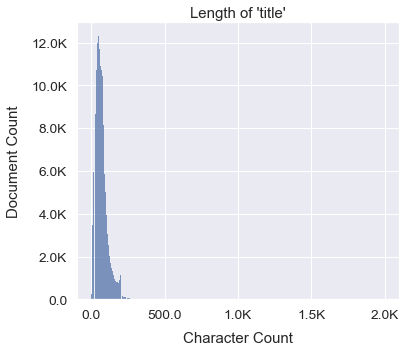

<IPython.core.display.Javascript object>

In [35]:
fig = lang.length_dist(titles.sample(10 ** 6), subset="title", tick_prec=1)

In [38]:
titles.at[titles.title.str.len().idxmax(), "title"]

'NP-FH50 Li-ion Battery Replacement For Sony Alpha AC-VQH10, DSLR-A230, DSLR-A290, DSLR-A330, SLR-380, DSLR-A390, DSC-HX1, DSC-HX100, DSC-HX100V, SC-X200, DSC-HX200V, DCR-DVD103, DCR-DVD105, DCR-DVD105E, DCR-DVD106, DCR-DVD106E, DCR-DVD108, DCR-DVD109, DCR-DVD109E, DCR-DVD202, DCR-DVD202E,DCR-DVD203, DCR-DVD203E, DCR-DVD205, DCR-DVD205E, DCR-DVD305, DCR-DVD305E, DCR-DVD306, DCR-DVD306E, DCR-DVD308, DCR-DVD308E , DCR-DVD403, DCR-DVD403E, DCR-DVD404, DCR-DVD404E, DCR-DVD405, DCR-DVD405E, DCR-DVD406, DCR-DVD406E, DCR-DVD407, DCR-DVD407E, DCR-DVD408, DCR-DVD505, DCR-DVD505E, DCR-DVD506, DCR-DVD508, DCR-DVD602, DCR-DVD602E, DCR-DVD605, DCR-DVD605E, DCR-DVD610, DCR-DVD610E, DCR-DVD650, DCR-DVD653, DCR-DVD653E, DCR-DVD703, DCR-DVD703E, DCR-DVD705, DCR-DVD705E, DCR-DVD708, DCR-DVD708E, DCR-DVD710, DCR-DVD710E, DCR-DVD755, DCR-DVD755E, DCR-DVD803, DCR-DVD803E, DCR-DVD805, DCR-DVD805E, DCR-DVD808, DCRDVD808, DVD808, DCR-DVD808E, DCRDVD808E, DVD808E DCR-DVD810, DCR-DVD810E, DCR-DVD850, DCR-DVD850

<IPython.core.display.Javascript object>

In [39]:
titles.at[titles.title.str.len().idxmin(), "title"]

'0'

<IPython.core.display.Javascript object>

In [43]:
titles = lang.trim_length_outliers(titles, subset="title", q_inner=0.98)
titles

        len_title
min             9
median         62
max           204


           n_trimmed  pct_trimmed
title         69,307            2
brand              0            0
total_obs     69,307            2


,title,brand
asin,,
6305121869,"Women Blouse, Ninasill Hooded Sweatshirt Coat ...",Ninasill_Blouse
6318708057,Coolred-Women Retro Split Sexy Skinny Premium ...,Coolred-Women
6342506256,Gaok Men's Retro Cotton Multi-Pocket Camo Carg...,Gaok
6342509379,QIBOE Men's Baggy Jeans Denim Sweatpants Loose...,QIBOE
6342522081,Crazy Explosion-proof Lens Polarized Sunglasse...,OLO
...,...,...
B0007IFUW8,National Audubon Society Sunflower Hearts (7 lbs),National Audubon Society
B0007IIOE4,19HP 42&quot; Yard Tractor,Electrolux
B0007IN33G,Echo Valley EV4061 Low Profile Globe Stand Black,Echo Valley


<IPython.core.display.Javascript object>

In [44]:
df = pd.merge(df, titles, left_index=True, right_index=True)
df

,description,main_cat,title,brand
asin,,,,
B000052XWP,"<P><STRONG>Advanced Pain Relief for the Arch, ...",all beauty,Dr Scholls Dyna Step-Women's,Dr Scholl's
B00005NWS1,This electric shoe polisher has a high torque ...,all beauty,First Class Electric Shoe Polisher,Jerdon
B000078OSM,Carry your light travel necessities comfortabl...,all beauty,Clava One Pocket 20&quot; Duffel (Vachetta Tan),Clava
B0002HS1MU,<strong>Maggie's Organic Cotton Tie Dye Crew ...,all beauty,Maggie's Organics - Organic Cotton Tie Dye Cre...,Maggie's Functional Organics
B00076MQL8,Presenting a beautiful timepiece attractive en...,all beauty,Ladies Tel Time Pendant Talking Watch,Tel-Time
...,...,...,...,...
B00ZOGIMZ0,<b>Oriental Style Durable Handle bag wireless...,video games,Oriental Style Durable Handle bag wireless Han...,by\n \n Oriental Style
B015ONJ9KO,"<div>+++Find, record, download, convert and en...",video games,Audials One 2016 [Download],by\n \n Audials AG
B015ONXBXA,<div>++Audials Tunebite Platinum - At a Glance...,video games,Audials Tunebite 2016 Platinum [Download],by\n \n Audials AG


<IPython.core.display.Javascript object>

In [46]:
del titles

<IPython.core.display.Javascript object>

# Filter Text

In [47]:
df = lang.decode_html_entities(df)
df.head()

,description,main_cat,title,brand
asin,,,,
B000052XWP,"<P><STRONG>Advanced Pain Relief for the Arch, ...",all beauty,Dr Scholls Dyna Step-Women's,Dr Scholl's
B00005NWS1,This electric shoe polisher has a high torque ...,all beauty,First Class Electric Shoe Polisher,Jerdon
B000078OSM,Carry your light travel necessities comfortabl...,all beauty,"Clava One Pocket 20"" Duffel (Vachetta Tan)",Clava
B0002HS1MU,<strong>Maggie's Organic Cotton Tie Dye Crew ...,all beauty,Maggie's Organics - Organic Cotton Tie Dye Cre...,Maggie's Functional Organics
B00076MQL8,Presenting a beautiful timepiece attractive en...,all beauty,Ladies Tel Time Pendant Talking Watch,Tel-Time


<IPython.core.display.Javascript object>

In [48]:
df = lang.lowercase(df)
df.head()

,description,main_cat,title,brand
asin,,,,
B000052XWP,"<p><strong>advanced pain relief for the arch, ...",all beauty,dr scholls dyna step-women's,dr scholl's
B00005NWS1,this electric shoe polisher has a high torque ...,all beauty,first class electric shoe polisher,jerdon
B000078OSM,carry your light travel necessities comfortabl...,all beauty,"clava one pocket 20"" duffel (vachetta tan)",clava
B0002HS1MU,<strong>maggie's organic cotton tie dye crew ...,all beauty,maggie's organics - organic cotton tie dye cre...,maggie's functional organics
B00076MQL8,presenting a beautiful timepiece attractive en...,all beauty,ladies tel time pendant talking watch,tel-time


<IPython.core.display.Javascript object>

Next I'll remove HTML tags. There are some visible in the 'description' field above, and I know that there are some in 'title'.

In [49]:
df = lang.strip_html_tags(df)
df.head()

,description,main_cat,title,brand
asin,,,,
B000052XWP,"advanced pain relief for the arch, heel, knee,...",all beauty,dr scholls dyna step-women's,dr scholl's
B00005NWS1,this electric shoe polisher has a high torque ...,all beauty,first class electric shoe polisher,jerdon
B000078OSM,carry your light travel necessities comfortabl...,all beauty,"clava one pocket 20"" duffel (vachetta tan)",clava
B0002HS1MU,maggie's organic cotton tie dye crew socks is ...,all beauty,maggie's organics - organic cotton tie dye cre...,maggie's functional organics
B00076MQL8,presenting a beautiful timepiece attractive en...,all beauty,ladies tel time pendant talking watch,tel-time


<IPython.core.display.Javascript object>

## Prune Nulls

In [50]:
df = df.mask(df.applymap(len, "ignore") == 0)
df.isna().sum()

description        35
main_cat            0
title              38
brand          164198
dtype: int64

<IPython.core.display.Javascript object>

In [51]:
df = df.dropna(subset=["description", "title", "main_cat"])
df.shape

(3950438, 4)

<IPython.core.display.Javascript object>

## Dedupe

In [52]:
df = df.drop_duplicates(subset=["title", "brand"])
df = df.drop_duplicates(subset=["description"])
df.shape

(3905974, 4)

<IPython.core.display.Javascript object>

In [53]:
data_checkpoint("data/filter_checkpoint")

<IPython.core.display.Javascript object>

## Revisit Length Outliers

In [177]:
df = pd.read_parquet("data/filter_checkpoint", engine="pyarrow")
df.head()

,description,title,brand,main_cat
asin,,,,
B000052XWP,"advanced pain relief for the arch, heel, knee,...",dr scholls dyna step-women's,dr scholl's,all beauty
B00005NWS1,this electric shoe polisher has a high torque ...,first class electric shoe polisher,jerdon,all beauty
B000078OSM,carry your light travel necessities comfortabl...,"clava one pocket 20"" duffel (vachetta tan)",clava,all beauty
B0002HS1MU,maggie's organic cotton tie dye crew socks is ...,maggie's organics - organic cotton tie dye cre...,maggie's functional organics,all beauty
B00076MQL8,presenting a beautiful timepiece attractive en...,ladies tel time pendant talking watch,tel-time,all beauty


<IPython.core.display.Javascript object>

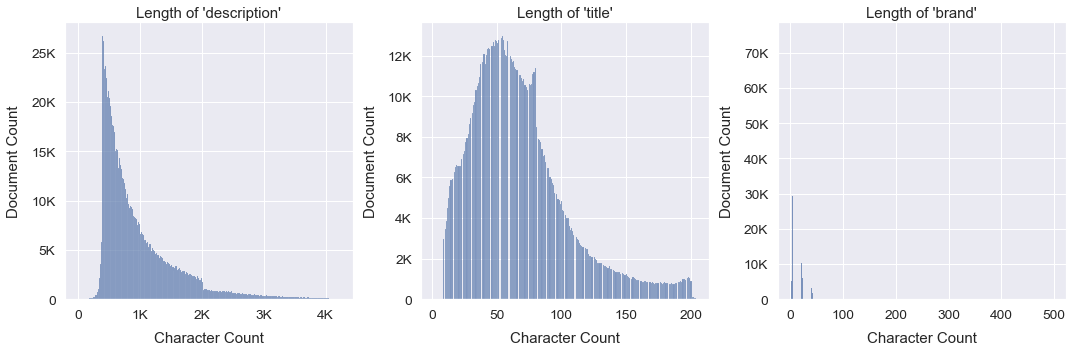

<IPython.core.display.Javascript object>

In [178]:
fig = lang.length_dist(df.sample(10 ** 6), subset=["description", "title", "brand"])

In [179]:
lang.other.length_info(df)

        len_description  len_title  len_brand
min                   1          2          1
median              761         61         12
max               4,230        204      1,986


<IPython.core.display.Javascript object>

I drop the shortest 1% of titles and descriptions.

In [180]:
df = lang.trim_length_outliers(df, subset=["title", "description"], q_lower=0.01)
df

        len_title  len_description
min            11              367
median         61              766
max           204            4,230


             n_trimmed  pct_trimmed
description     38,928            1
title           25,874            1
brand                0            0
main_cat             0            0
total_obs       64,694            2


,description,title,brand,main_cat
asin,,,,
B000052XWP,"advanced pain relief for the arch, heel, knee,...",dr scholls dyna step-women's,dr scholl's,all beauty
B00005NWS1,this electric shoe polisher has a high torque ...,first class electric shoe polisher,jerdon,all beauty
B000078OSM,carry your light travel necessities comfortabl...,"clava one pocket 20"" duffel (vachetta tan)",clava,all beauty
B0002HS1MU,maggie's organic cotton tie dye crew socks is ...,maggie's organics - organic cotton tie dye cre...,maggie's functional organics,all beauty
B00076MQL8,presenting a beautiful timepiece attractive en...,ladies tel time pendant talking watch,tel-time,all beauty
...,...,...,...,...
B00ZOGIMZ0,oriental style durable handle bag wireless han...,oriental style durable handle bag wireless han...,by oriental style,video games
B015ONJ9KO,"+++find, record, download, convert and enjoy m...",audials one 2016 [download],by audials ag,video games
B015ONXBXA,++audials tunebite platinum - at a glance++ un...,audials tunebite 2016 platinum [download],by audials ag,video games


<IPython.core.display.Javascript object>

Next, I drop the longest 1% and the shortest 1% of brand names.

In [181]:
df = lang.trim_length_outliers(
    df,
    subset="brand",
    q_inner=0.98,
)
df

        len_brand
min             3
median         12
max            40


             n_trimmed  pct_trimmed
description          0            0
title                0            0
brand           53,065            1
main_cat             0            0
total_obs       53,065            1


,description,title,brand,main_cat
asin,,,,
B000052XWP,"advanced pain relief for the arch, heel, knee,...",dr scholls dyna step-women's,dr scholl's,all beauty
B00005NWS1,this electric shoe polisher has a high torque ...,first class electric shoe polisher,jerdon,all beauty
B000078OSM,carry your light travel necessities comfortabl...,"clava one pocket 20"" duffel (vachetta tan)",clava,all beauty
B0002HS1MU,maggie's organic cotton tie dye crew socks is ...,maggie's organics - organic cotton tie dye cre...,maggie's functional organics,all beauty
B00076MQL8,presenting a beautiful timepiece attractive en...,ladies tel time pendant talking watch,tel-time,all beauty
...,...,...,...,...
B00ZOGIMZ0,oriental style durable handle bag wireless han...,oriental style durable handle bag wireless han...,by oriental style,video games
B015ONJ9KO,"+++find, record, download, convert and enjoy m...",audials one 2016 [download],by audials ag,video games
B015ONXBXA,++audials tunebite platinum - at a glance++ un...,audials tunebite 2016 platinum [download],by audials ag,video games


<IPython.core.display.Javascript object>

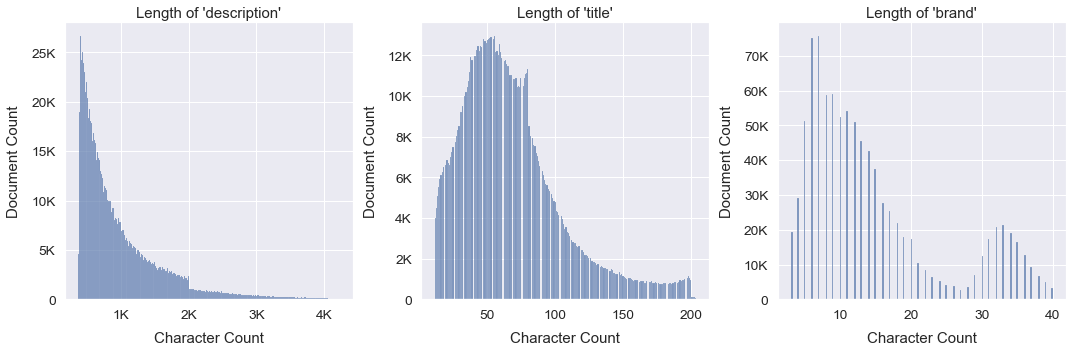

<IPython.core.display.Javascript object>

In [182]:
fig = lang.length_dist(df.sample(10 ** 6), subset=["description", "title", "brand"])

In [ ]:
data_checkpoint("data/length_checkpoint")

# Clean Brand

In [ ]:
df = pd.read_parquet("data/length_checkpoint", engine="pyarrow")
df.head()

In [183]:
brand_counts = df["brand"].value_counts()
brand_counts.head(15)

generic                 10255
unknown                  8963
yu-gi-oh!                7088
magic: the gathering     6522
invicta                  5974
amazon collection        5332
sony                     4817
various artists          4747
evan fischer             4116
samsung                  4014
various                  3794
toogoo(r)                3736
uxcell                   3551
empire                   3548
3drose                   3443
Name: brand, dtype: int64

<IPython.core.display.Javascript object>

In [184]:
null_brands = [
    "generic",
    "n/a",
    "no brand",
    "none",
    "not available",
    "null",
    "unavailable",
    "unbranded",
    "unknown",
    "learn more",
    "other",
    "anonymous",
]

brand_counts.loc[null_brands].sort_values()

unavailable          1
no brand             6
null                27
unbranded           75
other              108
anonymous          109
not available      113
learn more         227
n/a                551
none               632
unknown           8963
generic          10255
Name: brand, dtype: int64

<IPython.core.display.Javascript object>

In [185]:
df.loc[df.brand == "generic"]

,description,title,brand,main_cat
asin,,,,
B007IS408A,"made of high-quality canvas, very light and du...",beyond border korean fashion men waist bag fan...,generic,all beauty
B00AYS2TMA,size: c package include: 1x silicone bra ( sel...,invisible self-adhesive strapless backless sil...,generic,all beauty
B00AYS2T2A,size: a package include: 1x silicone bra ( sel...,leegoal self adhesive nubra strapless sheer si...,generic,all beauty
B00GLJDNN0,"description it is a light and soft underwear,t...",generic women girls sexy lingeries sleepwear l...,generic,all beauty
B00HNKJUOC,"description: occasion: wedding, engagements,pr...",wedding bridal prom crystal rhinestone butterf...,generic,all beauty
...,...,...,...,...
B00IXHP4IK,color: white. material: abs. size: 15cm x 11cm...,wired usb controller gamepad joystick joypad f...,generic,video games
B00S115NS4,"features: easy to install and dismantle, effec...",generic full housing shell case button kit for...,generic,video games
B00WJGWIUS,"features: easy to install and dismantle, effec...",generic full housing shell case button kit rep...,generic,video games


<IPython.core.display.Javascript object>

In [186]:
if "generic" in null_brands:
    null_brands.remove("generic")
df.loc[df.brand.isin(null_brands), "brand"] = np.nan
df.isna().sum()

description         0
title               0
brand          172215
main_cat            0
dtype: int64

<IPython.core.display.Javascript object>

In [187]:
by_brands = df.brand.str.startswith("by ").dropna()
df.dropna().loc[by_brands, ["brand"]]

,brand
asin,
B00KUSQ9NY,by alegory
B01CMJZLXM,by alegory
B00K0SXUBS,by w5swl
B00LZWGVFA,by gunnar optiks
B01E36DYAE,by bike
...,...
B00ZOGIMZ0,by oriental style
B015ONJ9KO,by audials ag
B015ONXBXA,by audials ag


<IPython.core.display.Javascript object>

In [188]:
df["brand"] = df.loc[:, "brand"].str.replace("^(by\s+)", "", regex=True)
df.dropna().loc[by_brands, ["brand"]]

,brand
asin,
B00KUSQ9NY,alegory
B01CMJZLXM,alegory
B00K0SXUBS,w5swl
B00LZWGVFA,gunnar optiks
B01E36DYAE,bike
...,...
B00ZOGIMZ0,oriental style
B015ONJ9KO,audials ag
B015ONXBXA,audials ag


<IPython.core.display.Javascript object>

In [189]:
amazon_pages = df.brand.str.extract(r"visit amazon's (.+) page")
amazon_pages = amazon_pages.dropna().squeeze()
df.loc[amazon_pages.index, "brand"] = amazon_pages
df.loc[amazon_pages.index]

,description,title,brand,main_cat
asin,,,,
0001049143,grade 7 up-scottish actor john cairney gives v...,the poems & songs of robert burns (harpercolli...,robert burns,books
0001473727,the greatest book on dispensational truth in t...,"the greatest book on ""dispensational truth"" in...",clarence larkin,books
0001384155,"“soft pastel illustrations lend a friendly, ca...",mog's family of cats,judith kerr,books
0001712691,"he bear she bear, what's the difference? not m...","he bear, she bear (beginner books)",stan berenstain,books
0001714384,p.j. funnybunny sometimes behaved badly. but t...,the very bad bunny (a beginner book) (beginner...,marilyn sadler,books
...,...,...,...,...
B004APDZBM,this 3 volume series of wonderfully illustrate...,the art of making leather cases - 3 volume set,al stohlman,books
0310948827,if you want to prepare for (or are already in)...,the god of all comfort bible study guide: find...,dee brestin,books
0842340351,harmony of the gospels a harmony of the gospel...,life application study bible nkjv,tyndale,books


<IPython.core.display.Javascript object>

In [190]:
regex = df.brand.value_counts().reset_index()
regex.columns = ["brand", "support"]
regex["brand"] = lang.strip_non_word(regex.loc[:, "brand"])
regex = regex.loc[
    (~regex.brand.str.contains("\s", regex=True))
    & (regex.brand != "various")
    & (regex.brand.str.len() > 3)
]
regex["brand"] = r"^" + regex.brand.map(re.escape) + r"\b"
regex.head(20)

,brand,support
0,^generic\b,10314
3,^invicta\b,5974
5,^sony\b,5296
8,^samsung\b,4014
11,^uxcell\b,3554
12,^empire\b,3549
13,^3drose\b,3443
15,^pokemon\b,3185
16,^disney\b,3121
17,^seiko\b,2696


<IPython.core.display.Javascript object>

In [191]:
no_brand = df.loc[df.brand.isna()]
fillers = lang.locate_patterns(regex.brand.head(100), no_brand.title)
fillers.sort_values()

asin
B0174OFIZ6          acer
B00005U2P0    activision
B01HJ09W8E        adidas
B003EHVBEA        adidas
B003EI94BQ        adidas
                 ...    
B00DI3W4NW        vktech
B004NT8VRS        yamaha
B005M3JQ9Q        yamaha
B00IWKVSR4        yamaha
B00963S6TE        yamaha
Name: locate_patterns, Length: 10371, dtype: object

<IPython.core.display.Javascript object>

In [192]:
df.loc[fillers.index, "brand"] = fillers
df.loc[fillers.index]

,description,title,brand,main_cat
asin,,,,
0898983428,628 pages of incredible sheet music for piano ...,columbia's colossal fake book (f2332fbx),columbia,books
1405288027,what would you do if you were famous? what's y...,lego (r) ninjago: book of secrets,lego,books
1423122607,#1 new york times bestselling author and illus...,disney princess collection (storybook collection),disney,books
145081137X,the disney school years memory keeper is a stu...,disney school years memory keeper,disney,books
1455039608,your daughter will love this disney princess 1...,disney princess storybook library set (volumes...,disney,books
...,...,...,...,...
B01HIJCH5Q,nike x liberty collection the nike air max 1 u...,nike wmns air max 1 ultra liberty qs 844135-10...,nike,amazon fashion
B01HILUTZO,the nike zoom lebron soldier 10 mens basketbal...,nike men's lebron 10 basketball shoe,nike,amazon fashion
B01HIMR5E6,the adidas® kids altarun boosts style and perf...,adidas kids womens altarun (little kid/big kid),adidas,amazon fashion


<IPython.core.display.Javascript object>

In [193]:
df.isna().sum()

description         0
title               0
brand          161844
main_cat            0
dtype: int64

<IPython.core.display.Javascript object>

In [194]:
no_brand = df.isna().groupby(df.main_cat).sum()[["brand"]]
no_brand["support"] = df.main_cat.value_counts()
no_brand = no_brand.rename(columns={"brand": "null_brand"})
no_brand["frac_null"] = no_brand["null_brand"] / no_brand["support"]
no_brand.sort_values("frac_null", ascending=False).head(10).style.bar("frac_null")

,null_brand,support,frac_null
main_cat,,,
fine art,303,303,1.000000
luxury beauty,6452,6460,0.998762
handmade,2218,2227,0.995959
movies & tv,23379,91482,0.255558
amazon fashion,107717,453070,0.237749
gift cards,10,140,0.071429
all beauty,510,10254,0.049737
collectibles & fine art,45,985,0.045685
magazine subscriptions,2,147,0.013605


<IPython.core.display.Javascript object>

In [195]:
df.loc[df.brand.isna(), "brand"] = ""
df.brand.value_counts().head(10)

none                    161847
generic                  10366
yu-gi-oh!                 7088
magic: the gathering      6522
invicta                   5974
nike                      5802
amazon collection         5332
sony                      5318
adidas                    5089
various artists           4748
Name: brand, dtype: int64

<IPython.core.display.Javascript object>

In [205]:
data_checkpoint("data/brand_checkpoint")

<IPython.core.display.Javascript object>

# Add Subcategory Info

In [6]:
df = pd.read_parquet("data/brand_checkpoint", engine="pyarrow")

<IPython.core.display.Javascript object>

In [7]:
subcats = pd.read_parquet("data/amazon", engine="pyarrow", columns=["category", "asin"])
subcats.set_index("asin", inplace=True)
subcats = subcats.loc[df.index].dropna().squeeze()
subcats

asin
B000052XWP    [Clothing, Shoes & Jewelry, Women, Shoes, Sand...
B000052XWP    [Clothing, Shoes & Jewelry, Women, Shoes, Sand...
B00005NWS1    [Clothing, Shoes & Jewelry, Shoe, Jewelry & Wa...
B00005NWS1    [Clothing, Shoes & Jewelry, Shoe, Jewelry & Wa...
B000078OSM    [Clothing, Shoes & Jewelry, Luggage & Travel G...
                                    ...                        
B00ZOGIMZ0    [Software, Music, MP3 Editing & Effects, MP3 S...
B015ONJ9KO    [Software, Digital Software, Music, CD Burning...
B015ONXBXA    [Software, Digital Software, Music, CD Burning...
B015OOLJ3I    [Software, Digital Software, Lifestyle & Hobbi...
B01DTJYXEW    [Software, Digital Software, Design & Illustra...
Name: category, Length: 3703847, dtype: object

<IPython.core.display.Javascript object>

In [8]:
subcats = subcats.explode()
filts = [lang.decode_html_entities, lang.lowercase, lang.strip_html_tags]
for filt in filts:
    subcats = filt(subcats)
subcats

asin
B000052XWP                            clothing, shoes & jewelry
B000052XWP                                                women
B000052XWP                                                shoes
B000052XWP                                              sandals
B000052XWP                            clothing, shoes & jewelry
                                    ...                        
B01DTJYXEW    architectural drawings - draw professional-qua...
B01DTJYXEW    engineering layouts - double-precision accurac...
B01DTJYXEW    shop drawings - entering specific values for d...
B01DTJYXEW    home projects - create do-it-yourself landscap...
B01DTJYXEW    other cad needs - create electronic schematics...
Name: category, Length: 16337953, dtype: object

<IPython.core.display.Javascript object>

In [9]:
subcats = lang.trim_length_outliers(subcats, q_inner=0.9)
subcats.head()

        len_category
min                5
median            15
max               43


           n_trimmed  pct_trimmed
category   1,260,921            8
total_obs  1,260,921            8


asin
B000052XWP    clothing, shoes & jewelry
B000052XWP                        women
B000052XWP                        shoes
B000052XWP                      sandals
B000052XWP    clothing, shoes & jewelry
Name: category, dtype: object

<IPython.core.display.Javascript object>

Next I drop duplicate subcategories (relative to each product).

In [10]:
subcats = utils.implode(subcats)
subcats.head()

asin
0000098906    [musical instruments, drums & percussion, hand...
0000143502                                [movies & tv, movies]
0000143529                                [movies & tv, movies]
0000143561                                [movies & tv, movies]
0000143588                                [movies & tv, movies]
Name: category, dtype: object

<IPython.core.display.Javascript object>

In [11]:
df = pd.merge(df, subcats, left_index=True, right_index=True, how="left")
df = df.rename(columns={"category": "sub_cat"})
df.head()

,description,title,brand,main_cat,sub_cat
asin,,,,,
B000052XWP,"advanced pain relief for the arch, heel, knee,...",dr scholls dyna step-women's,dr scholl's,all beauty,"[clothing, shoes & jewelry, women, shoes, sand..."
B00005NWS1,this electric shoe polisher has a high torque ...,first class electric shoe polisher,jerdon,all beauty,"[clothing, shoes & jewelry, shoe, jewelry & wa..."
B000078OSM,carry your light travel necessities comfortabl...,"clava one pocket 20"" duffel (vachetta tan)",clava,all beauty,"[clothing, shoes & jewelry, luggage & travel g..."
B0002HS1MU,maggie's organic cotton tie dye crew socks is ...,maggie's organics - organic cotton tie dye cre...,maggie's functional organics,all beauty,"[clothing, shoes & jewelry, novelty & more, cl..."
B00076MQL8,presenting a beautiful timepiece attractive en...,ladies tel time pendant talking watch,tel-time,all beauty,"[clothing, shoes & jewelry, women]"


<IPython.core.display.Javascript object>

In [12]:
del subcats

<IPython.core.display.Javascript object>

In [17]:
data_checkpoint("data/subcat_checkpoint")

['data/subcat_checkpoint\\main_cat=all beauty',
 'data/subcat_checkpoint\\main_cat=all electronics',
 'data/subcat_checkpoint\\main_cat=amazon devices',
 'data/subcat_checkpoint\\main_cat=amazon fashion',
 'data/subcat_checkpoint\\main_cat=amazon home',
 'data/subcat_checkpoint\\main_cat=appliances',
 'data/subcat_checkpoint\\main_cat=arts, crafts & sewing',
 'data/subcat_checkpoint\\main_cat=automotive',
 'data/subcat_checkpoint\\main_cat=baby',
 'data/subcat_checkpoint\\main_cat=books',
 'data/subcat_checkpoint\\main_cat=camera & photo',
 'data/subcat_checkpoint\\main_cat=car electronics',
 'data/subcat_checkpoint\\main_cat=cell phones & accessories',
 'data/subcat_checkpoint\\main_cat=collectibles & fine art',
 'data/subcat_checkpoint\\main_cat=computers',
 'data/subcat_checkpoint\\main_cat=digital music',
 'data/subcat_checkpoint\\main_cat=fine art',
 'data/subcat_checkpoint\\main_cat=gift cards',
 'data/subcat_checkpoint\\main_cat=gps & navigation',
 'data/subcat_checkpoint\\main_

<IPython.core.display.Javascript object>

# Add 'feature' text

In [3]:
df = pd.read_parquet("data/subcat_checkpoint", engine="pyarrow")
df.head()

,description,title,brand,sub_cat,main_cat
asin,,,,,
B000052XWP,"advanced pain relief for the arch, heel, knee,...",dr scholls dyna step-women's,dr scholl's,"[clothing, shoes & jewelry, women, shoes, sand...",all beauty
B00005NWS1,this electric shoe polisher has a high torque ...,first class electric shoe polisher,jerdon,"[clothing, shoes & jewelry, shoe, jewelry & wa...",all beauty
B000078OSM,carry your light travel necessities comfortabl...,"clava one pocket 20"" duffel (vachetta tan)",clava,"[clothing, shoes & jewelry, luggage & travel g...",all beauty
B0002HS1MU,maggie's organic cotton tie dye crew socks is ...,maggie's organics - organic cotton tie dye cre...,maggie's functional organics,"[clothing, shoes & jewelry, novelty & more, cl...",all beauty
B00076MQL8,presenting a beautiful timepiece attractive en...,ladies tel time pendant talking watch,tel-time,"[clothing, shoes & jewelry, women]",all beauty


<IPython.core.display.Javascript object>

In [47]:
feat = []

for path in glob.glob("data/amazon/part.*.parquet"):
    chunk = pd.read_parquet(
        path, engine="pyarrow", columns=["feature", "asin"],
    )
    chunk = chunk.set_index("asin").squeeze()
    chunk = chunk.drop(chunk.index.difference(df.index))
    chunk = chunk.str.join(" ")
    feat.append(chunk)
    print(f"{os.path.basename(path)} appended.")

feat = pd.concat(feat)
feat

part.0.parquet appended.
part.1.parquet appended.
part.10.parquet appended.
part.100.parquet appended.
part.101.parquet appended.
part.102.parquet appended.
part.103.parquet appended.
part.104.parquet appended.
part.105.parquet appended.
part.106.parquet appended.
part.107.parquet appended.
part.108.parquet appended.
part.109.parquet appended.
part.11.parquet appended.
part.110.parquet appended.
part.111.parquet appended.
part.112.parquet appended.
part.113.parquet appended.
part.114.parquet appended.
part.115.parquet appended.
part.116.parquet appended.
part.117.parquet appended.
part.118.parquet appended.
part.119.parquet appended.
part.12.parquet appended.
part.120.parquet appended.
part.121.parquet appended.
part.122.parquet appended.
part.123.parquet appended.
part.124.parquet appended.
part.125.parquet appended.
part.126.parquet appended.
part.127.parquet appended.
part.128.parquet appended.
part.129.parquet appended.
part.13.parquet appended.
part.130.parquet appended.
part.131.

asin
6305121869    Import Versatile Occasions - Great for Daily,C...
6318708057    100% Spandex Order Larger If You are Between S...
6342506256    Cotton Zipper closure Material:100% cotton Zip...
6342509379    Denim Zipper closure Material: cotton Style: h...
6342502315    Material:voile Size: 180cm x 95cm A scarf that...
                                    ...                        
B0007IFUW8    A favorite of bluebirds, buntings, chickadees,...
B0007IIOE4                         This item will ship by truck
B0007IN33G    Durable black coat finish Hand-welded Can be u...
B0007IQUUO    Inspired by the craftsman style of architectur...
B0007KP9SG    Display your American pride: Valley Forge Flag...
Name: feature, Length: 3880139, dtype: object

<IPython.core.display.Javascript object>

In [56]:
filts = [lang.decode_html_entities, lang.lowercase, lang.strip_html_tags]
for filt in filts:
    feat = filt(feat)
feat

asin
6305121869    import versatile occasions - great for daily,c...
6318708057    100% spandex order larger if you are between s...
6342506256    cotton zipper closure material:100% cotton zip...
6342509379    denim zipper closure material: cotton style: h...
6342502315    material:voile size: 180cm x 95cm a scarf that...
                                    ...                        
B0007IFUW8    a favorite of bluebirds, buntings, chickadees,...
B0007IIOE4                         this item will ship by truck
B0007IN33G    durable black coat finish hand-welded can be u...
B0007IQUUO    inspired by the craftsman style of architectur...
B0007KP9SG    display your american pride: valley forge flag...
Name: feature, Length: 3880139, dtype: object

<IPython.core.display.Javascript object>

In [57]:
lang.length_info(feat)

        len_feature
min               0
median          345
max           9,947


<IPython.core.display.Javascript object>

In [58]:
feat.loc[feat.str.len().idxmax()]

'sony kde-55xbr950,kdl-55ex640,kdl-55ex620,kdl-60ex700,kdl-55hx820,kdl-60ex720,kdl-60nx720,kdl-60ex500,kdl-60nx800,kdl-40s3000,kdl-55bx520,kdl-40v2500,kdl-40v3000,kdl-40vl130,kdl-40z4100,kdl-40ex700,kdl-60ex723,nsx-40gt1,kdl-40s2000,kdl-40s20l1,kdl-40w3000,kdl-40xbr3,kdl-40sl130,kdl-40xbr9,kdl-40v5100,kdl-40ve5,kdl-40w4100,kdl-40ex600,kdl-40ex523,kdl-40ex401,kdl-40d3000,kdl-40xbr5,kdl-v40xbr1,klv-40s200a,kdl-40xbr6,kdl-40s5100,kdl-40bx450,kdl-40nx700,kdl-40ex720,kdl-40s504,kdl-40bx420,fwd-40lx2f,kdl-40s2400,kdl-40xbr2,kdl-40xbr4,klv-s40a10,klv-40u100m,kdl-40xbr7,kdl-40z5100,klv-40zx1m,kdl-40ex640,kdl-40ex400,fwd-40lx1,kdl-40s2010,fwd-42pv1p/b,fwd-42px2,kde-42xbr950,kde-42xs955,kdl-40w5100,pfm-42x1,kdl-42xbr950,ke-42ts2,pfm-42b1,pfm-42b2,kdl-40ex500,kz-42ts1,kz-42ts1j,kz-42ts1u,fwd-42lx1,fwd-42pv1as,pfm-42v1,ke-42m1,ke-42ts2u,pfm-42b1u,pfm-42b2h,ke-42xbr900,ke-42xs910,kdl-46s5100,kdl-46v5100,kdl-46s2000,kdl-46s2010,kdl-46bx420,fwd-42pv1,kdl-46ex500,kdl-46ex523,kdl-46ex720,kdl-46hx729,kd

<IPython.core.display.Javascript object>

In [69]:
feat = lang.trim_length_outliers(feat, q_inner=0.98)
feat.head()

        len_feature
min              20
median          345
max           2,137


           n_trimmed  pct_trimmed
feature       47,387            1
total_obs     47,387            1


asin
6318708057    100% spandex order larger if you are between s...
6342506256    cotton zipper closure material:100% cotton zip...
6342509379    denim zipper closure material: cotton style: h...
6342502315    material:voile size: 180cm x 95cm a scarf that...
6342522545    100% polyester we use comfortable tissue to ma...
Name: feature, dtype: object

<IPython.core.display.Javascript object>

In [72]:
feat.loc[feat.str.len().idxmax()]

'stamped 925 sterling silver - this pony pendant is made from the finest sterling silver as hallmarked with the 925 metal stamp. 925 sterling silver is made from 92.5% silver and 7.5% copper. the copper is added to stabilize the silver so that it can hold its beautiful shape. 925 purity is a worthwhile investment for quality. nickel and lead free - your adorable horse charm is designed with absolutely no nickel or lead, making them safe for people with nickel and lead allergies. add this link chain anklet to your loved one\'s jewelry collection and have peace of mind every time it is worn. horse symbolism - symbolic for many, a horse represents freedom and spiritually that of inner strength. perfect present - a treasured gift for that little special someone in your life. buy this piece for your daughter, granddaughter, sister, niece or best friend, and know that you have purchased a suitable gift for any occasion or event such as valentine\'s day, easter, communion, graduation, christm

<IPython.core.display.Javascript object>

Next, I delete everything between brackets or parentheses.

In [90]:
feat = feat.str.replace(r"([{\(].+[\)}])", "", regex=True)
feat.loc["B00FSHD3YA"]

"stamped 925 sterling silver - this pony pendant is made from the finest sterling silver as hallmarked with the 925 metal stamp. 925 sterling silver is made from 92.5% silver and 7.5% copper. the copper is added to stabilize the silver so that it can hold its beautiful shape. 925 purity is a worthwhile investment for quality. nickel and lead free - your adorable horse charm is designed with absolutely no nickel or lead, making them safe for people with nickel and lead allergies. add this link chain anklet to your loved one's jewelry collection and have peace of mind every time it is worn. horse symbolism - symbolic for many, a horse represents freedom and spiritually that of inner strength. perfect present - a treasured gift for that little special someone in your life. buy this piece for your daughter, granddaughter, sister, niece or best friend, and know that you have purchased a suitable gift for any occasion or event such as valentine's day, easter, communion, graduation, christmas

<IPython.core.display.Javascript object>

In [92]:
feat = feat.str.split()
feat = feat.map(lang.strip_long, "ignore")
feat = feat.str.join(" ")
feat.loc["B00FSHD3YA"]

asin
6318708057    100% spandex order larger if you are between s...
6342506256    cotton zipper closure material:100% cotton zip...
6342509379    denim zipper closure material: cotton style: h...
6342502315    material:voile size: 180cm x 95cm a scarf that...
6342522545    100% polyester we use comfortable tissue to ma...
                                    ...                        
B0007IFUW8    a favorite of bluebirds, buntings, chickadees,...
B0007IIOE4                         this item will ship by truck
B0007IN33G    durable black coat finish hand-welded can be u...
B0007IQUUO    inspired by the craftsman style of architectur...
B0007KP9SG    display your american pride: valley forge flag...
Name: feature, Length: 3832752, dtype: object

<IPython.core.display.Javascript object>

In [94]:
df = pd.merge(df, feat, left_index=True, right_index=True, how="left")
df.head()

,description,title,brand,sub_cat,main_cat,feature
asin,,,,,,
0000044806,ayurveda holds secrets for all our skin proble...,medimix ayurvedic facewash - 100 ml (pack of 2),medimix,None,health & personal care,None
0000060259,if you feel that applying powder kumkum is tir...,lakme jewel sindoor (maroon) - pack of 2,lakme,None,health & personal care,None
0000098906,frog - rubbing its spine with the wooden stick...,"wooden percussion 3 piece set frog, cricket an...",wadsuwan shop,"[musical instruments, drums & percussion, hand...",musical instruments,wood percussion small 3 inches creates origina...
0000143502,rise and swine (good eats vol. 7) includes bon...,rise and swine (good eats vol. 7),alton brown,"[movies & tv, movies]",movies & tv,None
0000143529,disc 1: flour power (scones; shortcakes; south...,my fair pastry (good eats vol. 9),alton brown,"[movies & tv, movies]",movies & tv,None


<IPython.core.display.Javascript object>

In [102]:
del feat

<IPython.core.display.Javascript object>

In [99]:
df["feature"].fillna("", inplace=True)
df.head()

,description,title,brand,sub_cat,main_cat,feature
asin,,,,,,
0000044806,ayurveda holds secrets for all our skin proble...,medimix ayurvedic facewash - 100 ml (pack of 2),medimix,None,health & personal care,
0000060259,if you feel that applying powder kumkum is tir...,lakme jewel sindoor (maroon) - pack of 2,lakme,None,health & personal care,
0000098906,frog - rubbing its spine with the wooden stick...,"wooden percussion 3 piece set frog, cricket an...",wadsuwan shop,"[musical instruments, drums & percussion, hand...",musical instruments,wood percussion small 3 inches creates origina...
0000143502,rise and swine (good eats vol. 7) includes bon...,rise and swine (good eats vol. 7),alton brown,"[movies & tv, movies]",movies & tv,
0000143529,disc 1: flour power (scones; shortcakes; south...,my fair pastry (good eats vol. 9),alton brown,"[movies & tv, movies]",movies & tv,


<IPython.core.display.Javascript object>

In [105]:
data_checkpoint("data/feature_checkpoint")

['data/feature_checkpoint\\main_cat=all beauty',
 'data/feature_checkpoint\\main_cat=all electronics',
 'data/feature_checkpoint\\main_cat=amazon devices',
 'data/feature_checkpoint\\main_cat=amazon fashion',
 'data/feature_checkpoint\\main_cat=amazon home',
 'data/feature_checkpoint\\main_cat=appliances',
 'data/feature_checkpoint\\main_cat=arts, crafts & sewing',
 'data/feature_checkpoint\\main_cat=automotive',
 'data/feature_checkpoint\\main_cat=baby',
 'data/feature_checkpoint\\main_cat=books',
 'data/feature_checkpoint\\main_cat=camera & photo',
 'data/feature_checkpoint\\main_cat=car electronics',
 'data/feature_checkpoint\\main_cat=cell phones & accessories',
 'data/feature_checkpoint\\main_cat=collectibles & fine art',
 'data/feature_checkpoint\\main_cat=computers',
 'data/feature_checkpoint\\main_cat=digital music',
 'data/feature_checkpoint\\main_cat=fine art',
 'data/feature_checkpoint\\main_cat=gift cards',
 'data/feature_checkpoint\\main_cat=gps & navigation',
 'data/featu

<IPython.core.display.Javascript object>

# Construct Model Text

In [4]:
df = pd.read_parquet("data/feature_checkpoint", engine="pyarrow")
df

,description,title,brand,sub_cat,feature,main_cat
asin,,,,,,
1441072241,after rising in the appalachian mountains of v...,come tell me how you lived: native american hi...,enter the arena,"[books, history, americas, native american]",,all beauty
6090113980,note : we cannot guarantee 100% that you will ...,prayer rug carpet mat gebetsteppich islamic mu...,bonballoon,"[home & kitchen, home dcor, area rugs, runners...",,all beauty
7250468162,no7 stay perfect foundation now stays perfect ...,no7 stay perfect foundation cool vanilla by no7,no7,None,,all beauty
8279996397,"according to the legend, in 1613, two brothers...",imagen bendita por su santidad our lady of cha...,chango,None,,all beauty
9197882747,"if you can design one thing, you can design ev...",hall of femmes: lella vignelli (hall of femmes),oyster press,None,,all beauty
...,...,...,...,...,...,...
B01HJ14FDA,this bundle includes the full game plus the fo...,jojo eyes of heaven complete bundle - ps4 [dig...,bandai,"[video games, playstation 4, digital games & d...",,video games
B01HJ14OT0,"the technomancer takes you to mars, where you ...",the technomancer - ps4 [digital code],focus home interactive,"[video games, playstation 4, digital games & d...",,video games
B01HJ14TTA,the season pass includes three level packs tha...,lego star wars: the force awakens season pass ...,warner bros.,"[video games, playstation 4, digital games & d...",dlc requires base game,video games


<IPython.core.display.Javascript object>

In [5]:
text_schema = "{title}. {description}. {feature}. {brand}."


def construct_text(item, schema=text_schema):
    text = schema.format(**item)
    return lang.strip_extra_periods(text)


construct_text(df.iloc[0])

'come tell me how you lived: native american history of the tennessee valley. after rising in the appalachian mountains of virginia and north carolina, the tennessee river flows in a southwesterly direction through tennessee making a bend to the west in alabama and touching mississippi. the river turns to the north through tennessee again and finally into kentucky where it joins the ohio river. for thousands of years, native americans lived in and around the river valley in great numbers. even though lakes from the tennessee valley authority dams have covered the evidence left at many of the indian sites, this book attempts to show how these first americans lived. numerous pictures are shown to help illustrate their long and interesting story. enter the arena.'

<IPython.core.display.Javascript object>

In [6]:
df["text"] = df.apply(construct_text, axis=1)
df["text"].head()

asin
1441072241    come tell me how you lived: native american hi...
6090113980    prayer rug carpet mat gebetsteppich islamic mu...
7250468162    no7 stay perfect foundation cool vanilla by no...
8279996397    imagen bendita por su santidad our lady of cha...
9197882747    hall of femmes: lella vignelli (hall of femmes...
Name: text, dtype: object

<IPython.core.display.Javascript object>

# Export

In [9]:
data_checkpoint("data/amazon_clean")

['data/amazon_clean\\main_cat=all beauty',
 'data/amazon_clean\\main_cat=all electronics',
 'data/amazon_clean\\main_cat=amazon devices',
 'data/amazon_clean\\main_cat=amazon fashion',
 'data/amazon_clean\\main_cat=amazon home',
 'data/amazon_clean\\main_cat=appliances',
 'data/amazon_clean\\main_cat=arts, crafts & sewing',
 'data/amazon_clean\\main_cat=automotive',
 'data/amazon_clean\\main_cat=baby',
 'data/amazon_clean\\main_cat=books',
 'data/amazon_clean\\main_cat=camera & photo',
 'data/amazon_clean\\main_cat=car electronics',
 'data/amazon_clean\\main_cat=cell phones & accessories',
 'data/amazon_clean\\main_cat=collectibles & fine art',
 'data/amazon_clean\\main_cat=computers',
 'data/amazon_clean\\main_cat=digital music',
 'data/amazon_clean\\main_cat=fine art',
 'data/amazon_clean\\main_cat=gift cards',
 'data/amazon_clean\\main_cat=gps & navigation',
 'data/amazon_clean\\main_cat=grocery',
 'data/amazon_clean\\main_cat=handmade',
 'data/amazon_clean\\main_cat=health & person

<IPython.core.display.Javascript object>

In [12]:
for path in glob.glob("data/*_checkpoint"):
    shutil.rmtree(path)
    print(f"'{path}' deleted.")

'data\brand_checkpoint' deleted.
'data\feature_checkpoint' deleted.
'data\subcat_checkpoint' deleted.


<IPython.core.display.Javascript object>